In [1]:
%matplotlib ipympl
import glob
import pandas as pd
import numpy as np
import scipy
import librosa


import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
SR = 15000

frfs = []
for session in [1, 3]:
    for violin in ["Klimke", "Levaggi", "Stoppani"]:
        files = glob.glob(
            f"../data/raw/CNSM/Session {session}/Admittances/*{violin}*.mat"
        )
        ref = None
        for file in files:
            mat = scipy.io.loadmat(file)
            sr = mat["freq"][0, 0]
            n_fft = mat["npts"][0, 0]
            if n_fft != 32768:
                continue
            f = np.linspace(0, sr // 2, n_fft // 2 + 1)
            X = mat["yspec"][:, 1]
            Y = mat["yspec"][:, 0]

            x = np.fft.irfft(X, n_fft)
            y = np.fft.irfft(Y, n_fft)

            x = librosa.resample(x, orig_sr=sr, target_sr=SR)
            y = librosa.resample(y, orig_sr=sr, target_sr=SR)

            X = np.fft.rfft(x, 1024)
            Y = np.fft.rfft(y, 1024)

            sr = SR
            n_fft = 1024
            f = np.linspace(0, sr // 2, n_fft // 2 + 1)
            H = np.abs(Y / X)
            H = 20 * np.log10(H)

            if type(ref) != np.ndarray:
                ref = H

            a = (H - ref).sum() / len(H)
            H += a

            frf = {
                "file": file,
                "violin": violin,
                "session": session,
                "sr": sr,
                "n_fft": n_fft,
                "f": f,
                "X": X,
                "Y": Y,
                "H": H,
            }
            frfs.append(frf)

frfs = pd.DataFrame(frfs)
print(frfs[["file", "violin", "session"]])

                                                 file    violin  session
0   ../data/raw/CNSM/Session 1/Admittances/Admitt_...    Klimke        1
1   ../data/raw/CNSM/Session 1/Admittances/Admitt_...    Klimke        1
2   ../data/raw/CNSM/Session 1/Admittances/Admitt_...    Klimke        1
3   ../data/raw/CNSM/Session 1/Admittances/Admitt_...   Levaggi        1
4   ../data/raw/CNSM/Session 1/Admittances/Admitt_...   Levaggi        1
5   ../data/raw/CNSM/Session 1/Admittances/Admitt_...   Levaggi        1
6   ../data/raw/CNSM/Session 1/Admittances/Admitt_...   Levaggi        1
7   ../data/raw/CNSM/Session 1/Admittances/Admitt_...  Stoppani        1
8   ../data/raw/CNSM/Session 1/Admittances/Admitt_...  Stoppani        1
9   ../data/raw/CNSM/Session 1/Admittances/Admitt_...  Stoppani        1
10  ../data/raw/CNSM/Session 1/Admittances/Admitt_...  Stoppani        1
11  ../data/raw/CNSM/Session 3/Admittances/Klimke_...    Klimke        3
12  ../data/raw/CNSM/Session 3/Admittances/Klimke_.

## Admittances plots

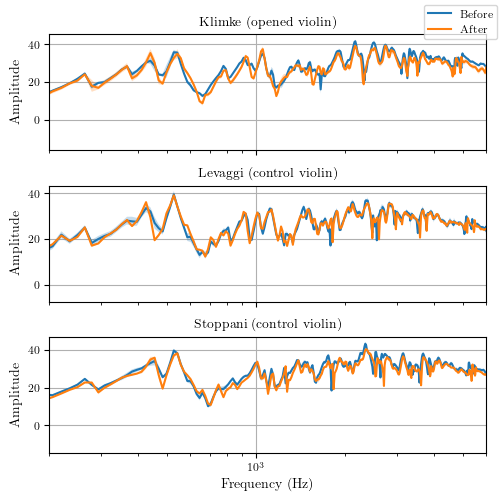

In [80]:
def std(group):
    group = np.vstack(group)
    std = np.std(group, axis=0)
    return std


# Plot only between f1 and f2
mask = (frfs.f[0] > 0) & (frfs.f[0] < 50000)

color = {"Klimke": "blue", "Levaggi": "orange", "Stoppani": "green"}
color = {"Klimke": "black", "Levaggi": "black", "Stoppani": "black"}

mpl.style.use("/home/hugo/Thèse/common/styles.mplstyle")

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(5, 5))
stats = frfs.groupby(["violin", "session"])["H"].agg(["mean", std])


stats["f"] = frfs.groupby(["violin", "session"])["f"].first()

for i, row in stats.iterrows():
    violin, session = row.name
    ax = list(color.keys()).index(violin)
    axs[ax].plot(
        row["f"][mask],
        row["mean"][mask],
        # c=f"{"green" if session==1 else "red"}",
        # linestyle="-" if session == 1 else "--",
        # linewidth=0.5,
        # alpha=0.8,
        # label=f"{"Before" if session==1 else "After"}",
    )
    axs[ax].fill_between(
        row["f"][mask],
        row["mean"][mask] + row["std"][mask],
        row["mean"][mask] - row["std"][mask],
        alpha=0.25,
        # color=color[violin],
        label="_nolegend_",
    )
    axs[ax].set_title(
        f"{violin}{" (opened violin)" if violin == "Klimke" else " (control violin)"}"
    )
    axs[ax].set_xscale("log")
    axs[ax].set_xlim([200, 6000])
    axs[ax].set_ylabel("Amplitude")
    axs[ax].grid(True)

axs[-1].set_xlabel("Frequency (Hz)")
fig.legend(("Before", "After"))
# fig.suptitle("Admittances before and after the opening phase for each violin")
fig.savefig("../reports/figures/admittances.png")

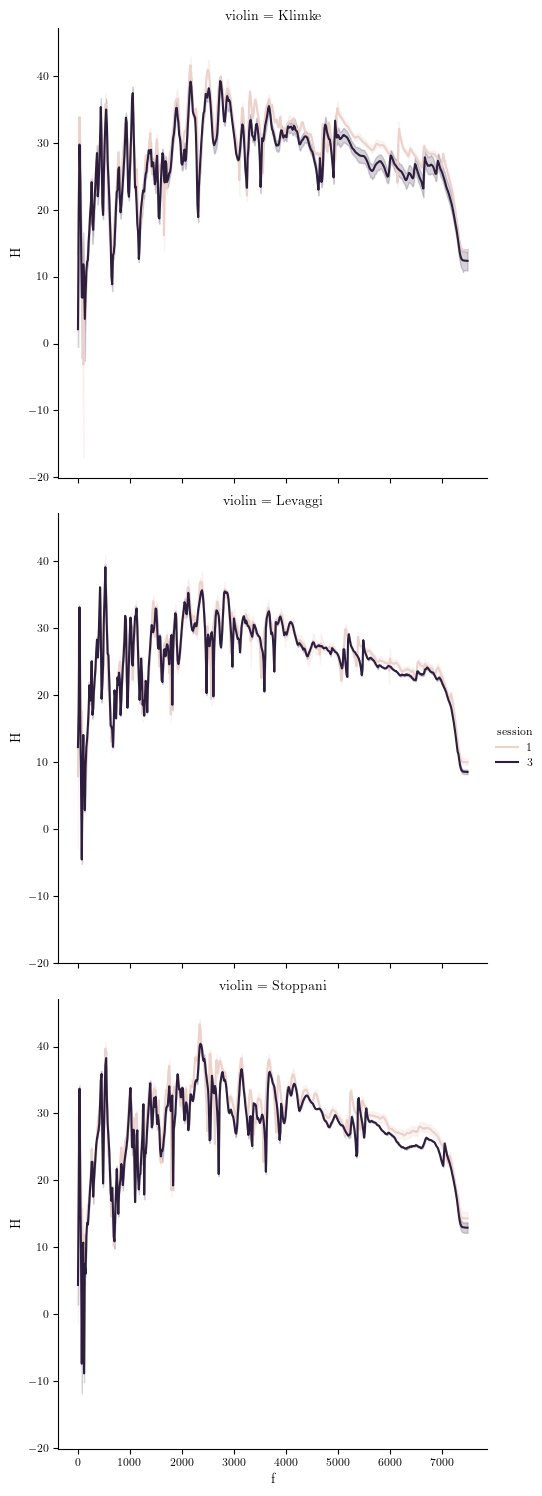

In [59]:
frfs_long = frfs.explode(["f", "H"])

sns.relplot(
    data=frfs_long,
    kind="line",
    x="f",
    y="H",
    hue="session",
    row="violin",
)

## Euclidean distances between admittances

In [81]:
for violin in ["Klimke", "Levaggi", "Stoppani"]:
    print(violin)
    before = stats.loc[(violin, 1)]["mean"][mask]
    after = stats.loc[(violin, 3)]["mean"][mask]
    print(np.linalg.norm(after - before))

Klimke
62.357144972498176
Levaggi
50.93544137366412
Stoppani
71.37858197594072
